In [1]:
# Define colors
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"
Pitt.DGray<- "#75787B"
Pitt.Gray <- "#97999B"
Pitt.LGray <- "#C8C9C7"
# ggplot preferences
library("ggplot2")
library("repr")
options(repr.plot.width=10, repr.plot.height=10/1.68)
Pitt.Theme<-theme( panel.background = element_rect(fill = "white", linewidth = 0.5, linetype = "solid"),
  panel.grid.major = element_line(linewidth = 0.5, linetype = 'solid', colour =Pitt.Gray), 
  panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = "white")
  )
base<- ggplot() +aes()+ Pitt.Theme

# Standard Errors for Transformations
---

Given that we're now in a world of very non-linear models, we would like some way of being able to take our estimates of the model parameters and standard errors, and to understand them through more concrete **outcomes** from the model.

### Examples:
Suppose we've estimated a probability each type of customer buys a product across an array of prices

We now want to use this model to figure out things like:
* What's the predicted  profits if I run a sale event?
* How would this compare to my predicted profit under the standard prices?
* What's the difference!?

We'll talk a little more about probabilities soon when we begin talking about **Probit** and **Logit** models. For now, let's look at an example of streaks:
* That is we will model the probability of the end of a streak occuring with a fixed probability $p$
* Our data on observables is the duration of these streaks
* We will model this with a *geometric* random variable

The geometric random variable is another model of *counts*, here under the assumption that 
there is a constant chance after each draw for the streak to end. The probability the streak lasts for $x=0,1,2,\ldots$ periods is given by:
$$ \Pr\left\{X=x\right\}=(1-p)^{x}p$$ 

Let's draw some data on these streaks, where we'll set the probability of the streak ending as $p=\tfrac{1}{8}$

In [2]:
Streak.Data<- rgeom(100,1/8) #the R version measures streaks starting at 0...
head(Streak.Data)
summary(Streak.Data)

[1] 4 8 5 6 8 1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       2       5       8      11      58 

Let's me just quickly visualize how this count variable differs from the Poisson:

In [5]:
x <- 0:20 
library(tidyr)
# Here I use gather to make the data.frame "tidy", so I can make the legend more easily...
df.probs <- gather(data.frame(x=x,poisson=dpois(x,lambda=8), geom=dgeom(x,prob=1/8)),key="dist",value="pmf",c("poisson","geom"))
head(df.probs,3)
tail(df.probs,3)

,x,dist,pmf
,<int>,<chr>,<dbl>
1,0,poisson,0.0003354626
2,1,poisson,0.0026837010
3,2,poisson,0.0107348041


,x,dist,pmf
,<int>,<chr>,<dbl>
40,18,geom,0.011299389
41,19,geom,0.009886966
42,20,geom,0.008651095


Draw the probability at each $x$ value:

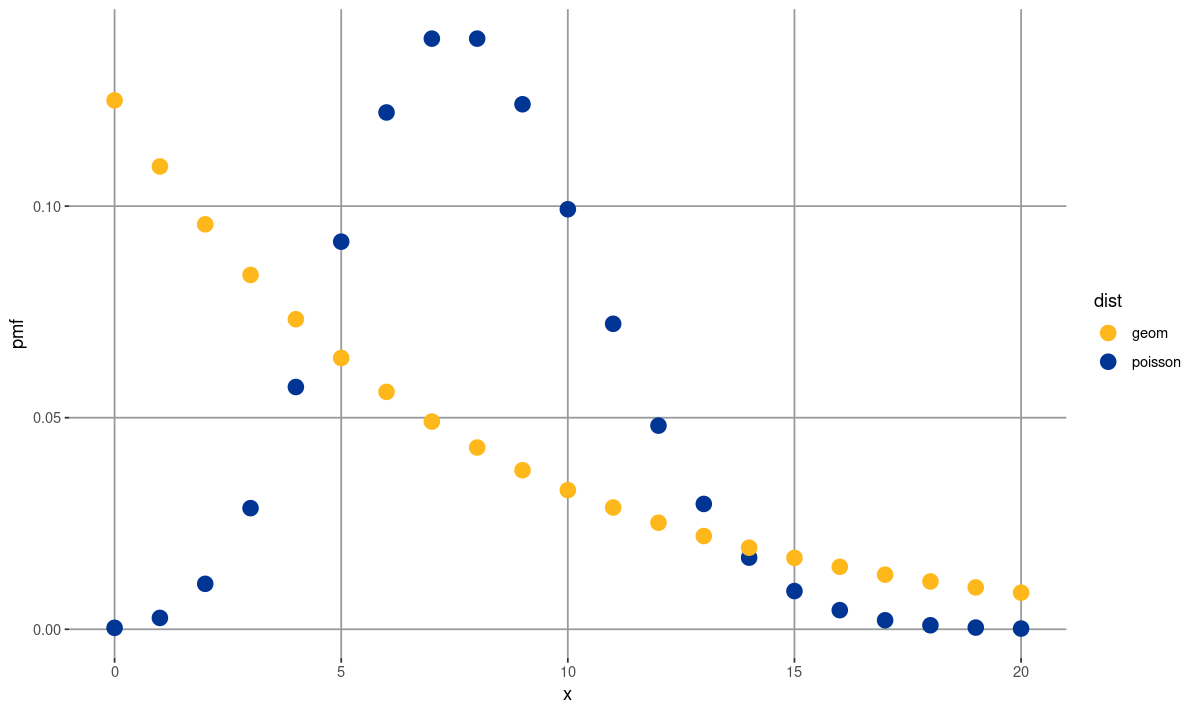

In [6]:
ggplot(df.probs,aes(x=x,y=pmf,color=dist))+ Pitt.Theme+
geom_point(size=4)+ scale_color_manual(values = c("poisson" = Pitt.Blue,"geom" =Pitt.Gold))

So the geometric random variable has a constant rate of decay, where the probability of reaching a value of $x+1$ is $(1-p)$ times the probability of reaching $x$!

For example, suppose we are using these measured durations over the day gaps between using a costly resource: 
* we've calculated how we can use the data to estimate the probability $\hat{p}$ that the streak ends each day in the quiz
* and the method of calculating a standard error for it given by $\hat{\sigma}_p$

Let's quickly run an estimation for our data

In [7]:
# here I use a method that allows for bounds as my probability has to lie in [0,1]
Log.Likelihood.F <- function(p)  sum( sapply( Streak.Data , dgeom,  prob=p, log=TRUE)  )
est <- optim(0.1,Log.Likelihood.F,control= list(fnscale=-1), method="Brent",lower=0,upper=1)
pHat <- est$par
pHat 

[1] 0.1111111

**Estimate**: So our estimator of p (which we set to $\tfrac{1}{8}=0.125$) is:

In [8]:
pHat

[1] 0.1111111

Let's calculate the standard error on our estimate using the score and a numerical derivative:

In [9]:
Score.vector <- (sapply( Streak.Data , dgeom,  prob=pHat+1e-6, log=TRUE)-
                  sapply( Streak.Data , dgeom,  prob=pHat-1e-6, log=TRUE) )/(2*1e-6)
sigma.p <- sqrt(( 1/mean(Score.vector**2) )/length(Streak.Data))
sigma.p

[1] 0.009518954

**Std.Error:** So our estimator for the standard deviation of the estimate is:

In [10]:
sigma.p

[1] 0.009518954

**Confidence Interval**: We can use the estimate $\hat{p}$ and the standard error  $\hat{\sigma}_p$ to construct a 95-percent confidence interval for $p$ just as you did with linear models:
 $$\text{95% Conf Int: } \left[\hat{p}- 1.96\times\hat{\sigma}_{p},\hat{p}+ 1.96\times\hat{\sigma}_{p}\right] $$

Estimating this and putting it together in a vector for later use:

In [11]:
crit.value <- qnorm(0.975) # get the exact critical value from normal distribution
# put it all together
pConfInt <- c("lower.limit"=pHat-crit.value* sigma.p,"estimate"=pHat, "upper.limit"=pHat+crit.value* sigma.p)
pConfInt

lower.limit    estimate upper.limit 
  0.0924543   0.1111111   0.1297679

But knowing that the 95% confidence interval for $\hat{p}$ is  $\hat{p}\pm 1.96\times\hat{\sigma}_p$ isn't really an end outcome, it's more of a necessary ingredient. We need to put this estimate back into the model to calculate what we really care about.

For example, suppose the streaks that we're measuring are the number of days without the need to use an inventory item that provides safety protection for 24 hours. Your firm holds two of these items in inventory, which are renewed by a sub-contractor every Monday morning. However, if the inventory is depleted the production line has to stop with a costly delay. 

**What are the chances of this delay?**

#### Plugging the parameter into another distribution
While our data came in the form of streaks, and these weren't constrained to occur in a fixed window, the application is asking a question about a very different type of random variable: a binomial!

#### Binomial
A binomial distribution ask the chance that $x$ events each with an independent probability $p$ of occurring out of $n$ possible draws. The probability of this is given by:
 $$ \Pr\left\{X=x\right\}=\frac{n!}{x!(n-x)!}p^x(1-p)^{n-x}$$
 
* The first part of this, the $\frac{n!}{x!(n-x)!}$ term is often abbreviated as $\binom{n}{x}$ or *n choose x* in words, enumerates the number of different ways we could have got $x$ successes and $n-x$ failures.
* The second part of this is the chance that the first $x$ draws were successes the last $n-x$ failures.

* So we have our parameter estimate $\hat{p}$ which gives us our **estimate** for the chance that we use one of the safety product in a 24 hour period
* But we want to understnad what that means for how many uses there are in a week (so $n=7$ if our factory runs 7 days a week).
* Finally, using the binomial we want to figure out the chances that we use three or more products, so the chance that $\Pr\left\{X\geq 3\right\}$  

The probability of exactly $x$ uses in 7 days is given by:
$$q(x):=\Pr\left\{X=x\right\}=\binom{7}{x}p^x(1-p)^{7-x}$$
so the probability we want to calculate is:
$$ Q=1-q(0)-q(1)-q(2) $$

It's easy enough to code this up as a function of the parameter $p$ using the binomial probability given by the `dbinom()` function!:

In [12]:
Q <- function(p)  1-dbinom(x=0,size=7,prob=p)- dbinom(x=1,size=7,prob=p)- dbinom(x=2,size=7,prob=p) 

We can then draw the graph for the probability Q as a function of $p$, where I overlay our estimate $\hat{p}$ as the vertical blue line:

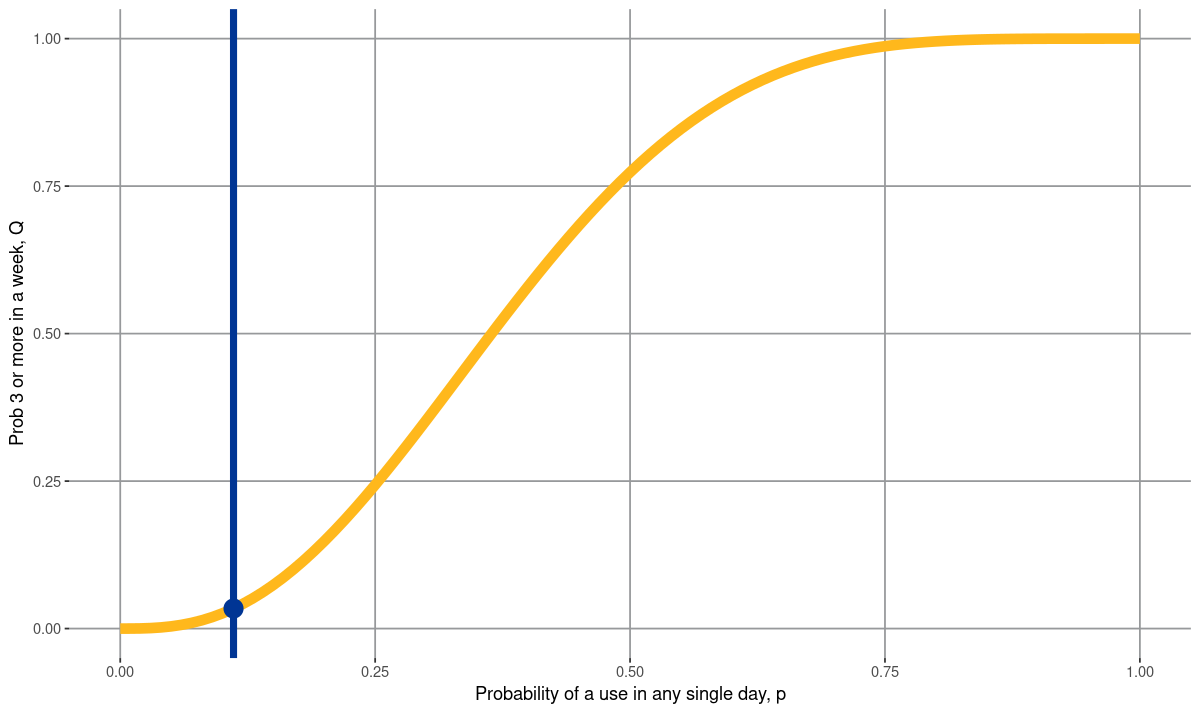

In [13]:
base + geom_function( fun = Q, colour=Pitt.Gold, linewidth=3) + geom_vline(xintercept=pHat,color=Pitt.Blue,linewidth=2)+
geom_point(aes(x=pHat,y=Q(pHat)),color=Pitt.Blue,size=5)+
xlim(0, 1)+xlab("Probability of a use in any single day, p")+ylab("Prob 3 or more in a week, Q")

Because this graph seems relatively well-behaved -- moreso, it is strictly increasing in the input $p$ -- one way we could approach calculating the standard error on the prediction is to just calculate the best/worst case for $p$ from our confidence interval from before, and then look at these values for the function $Q(\cdot)$.

Reminding ourselves that:
* Our theory says that $\hat{p}$ will be asymptotically normally distributed around the true value $p$
* We used this to build a confidence interval for the true value $p$ using the assessed standard error 

In [14]:
pConfInt

lower.limit    estimate upper.limit 
  0.0924543   0.1111111   0.1297679

So let's overlay the assessed normal and confidence interval on our graph of $Q(p)$:

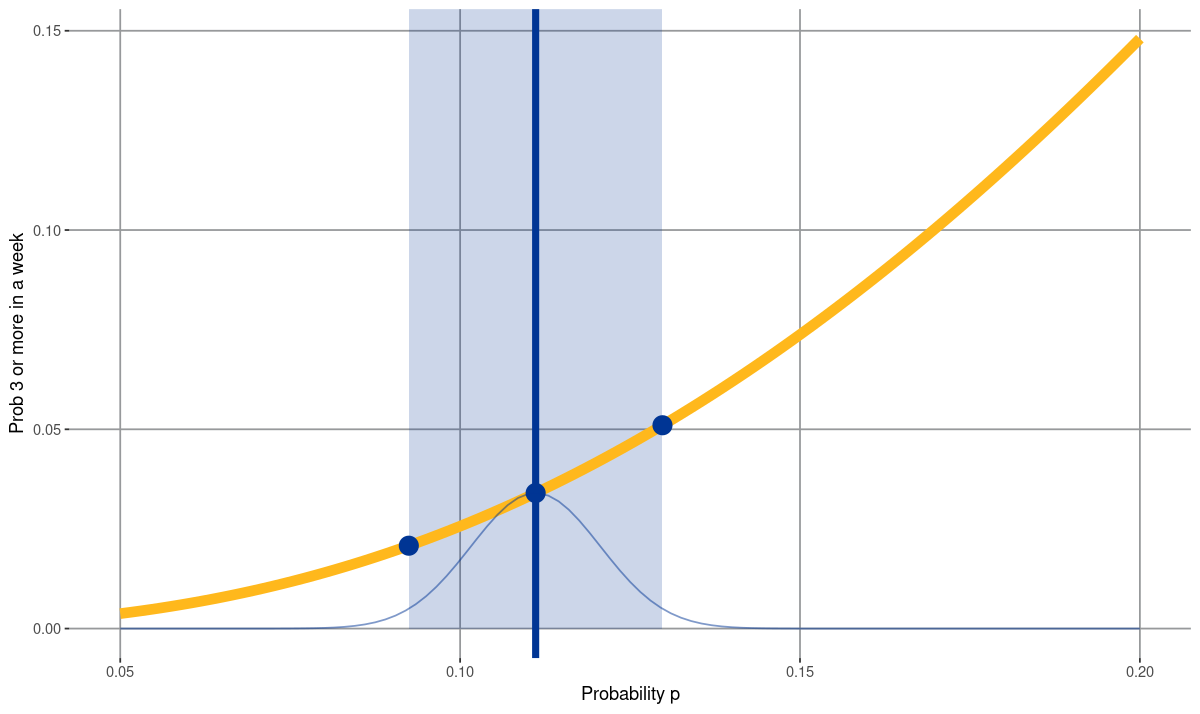

In [15]:
base + 
geom_rect(aes(xmin=pConfInt["lower.limit"],xmax=pConfInt["upper.limit"],ymin=0,ymax=Inf),alpha=0.2,fill=Pitt.Blue)+ #draw a rectangle for conf-int
geom_function( fun = Q, colour=Pitt.Gold, linewidth=3)+ # draw the Q function
geom_vline(xintercept=pHat,color=Pitt.Blue,linewidth=2)+ #  draw the vertical line
geom_point(aes(x=pConfInt,y=Q(pConfInt)),color=Pitt.Blue,size=5)+ # Draw the 3 points on the function
# overlay the asymptotic distribution for p scaled to fit
geom_function(fun=function(x) Q(pHat)*dnorm(x,mean=pHat,sd=sigma.p)/dnorm(pHat,mean=pHat,sd=sigma.p), color=Pitt.Blue,alpha=0.5)+  
xlim(0.05, 0.2)+xlab("Probability p")+ylab("Prob 3 or more in a week")

So in this cases we could just calculate the upper- and lower-confidence values for our statistic separately: 

In [16]:
QconfInt<-Q(pConfInt)
round(rbind( "p"= pConfInt, "Q"= QconfInt),3)

,lower.limit,estimate,upper.limit
p,0.092,0.111,0.130
Q,0.021,0.034,0.051


Similarly, if we wanted to figure out the probability that we didn't need to call out for an emergency delivery in a year?

In [17]:
No.Call.Year<- function(p) (1-Q(p))^52

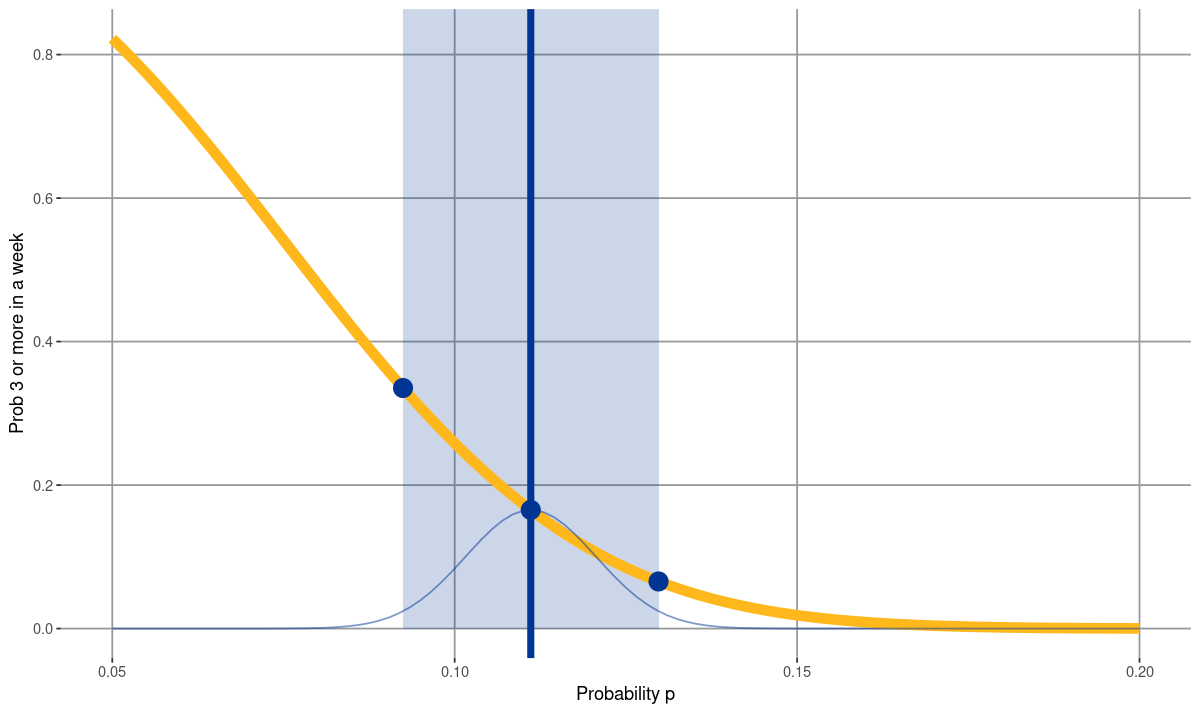

In [18]:
base + 
geom_rect(aes(xmin=pConfInt["lower.limit"],xmax=pConfInt["upper.limit"],ymin=0,ymax=Inf),alpha=0.2,fill=Pitt.Blue)+ #draw a rectangle for conf-int
geom_function( fun = No.Call.Year, colour=Pitt.Gold, linewidth=3)+ # draw the NoCall function
geom_vline(xintercept=pHat,color=Pitt.Blue,linewidth=2)+ # draw the vertical line
geom_point(aes(x=pConfInt,y=No.Call.Year(pConfInt)),color=Pitt.Blue,size=5)+ # Draw the 3 points on the function
# overlay the asymptotic distribution for p scaled to fit
geom_function(fun=function(x) No.Call.Year(pHat)*dnorm(x,mean=pHat,sd=sigma.p)/dnorm(pHat,mean=pHat,sd=sigma.p), color=Pitt.Blue,alpha=0.5)+  
xlim(0.05, 0.2)+xlab("Probability p")+ylab("Prob 3 or more in a week")

In [19]:
NoCallConfInt=c(No.Call.Year(pConfInt["upper.limit"]), No.Call.Year(pConfInt["estimate"]), No.Call.Year(pConfInt["lower.limit"]))
round(rbind( "p"= pConfInt, "Q"= QconfInt,"No.Call"=NoCallConfInt),3)

,lower.limit,estimate,upper.limit
p,0.092,0.111,0.130
Q,0.021,0.034,0.051
No.Call,0.066,0.165,0.335


However, other statistics/transformations may be less well-behaved. For example, suppose we're trying to calculate the probability that there are either two or three weeks with a call out for the year?

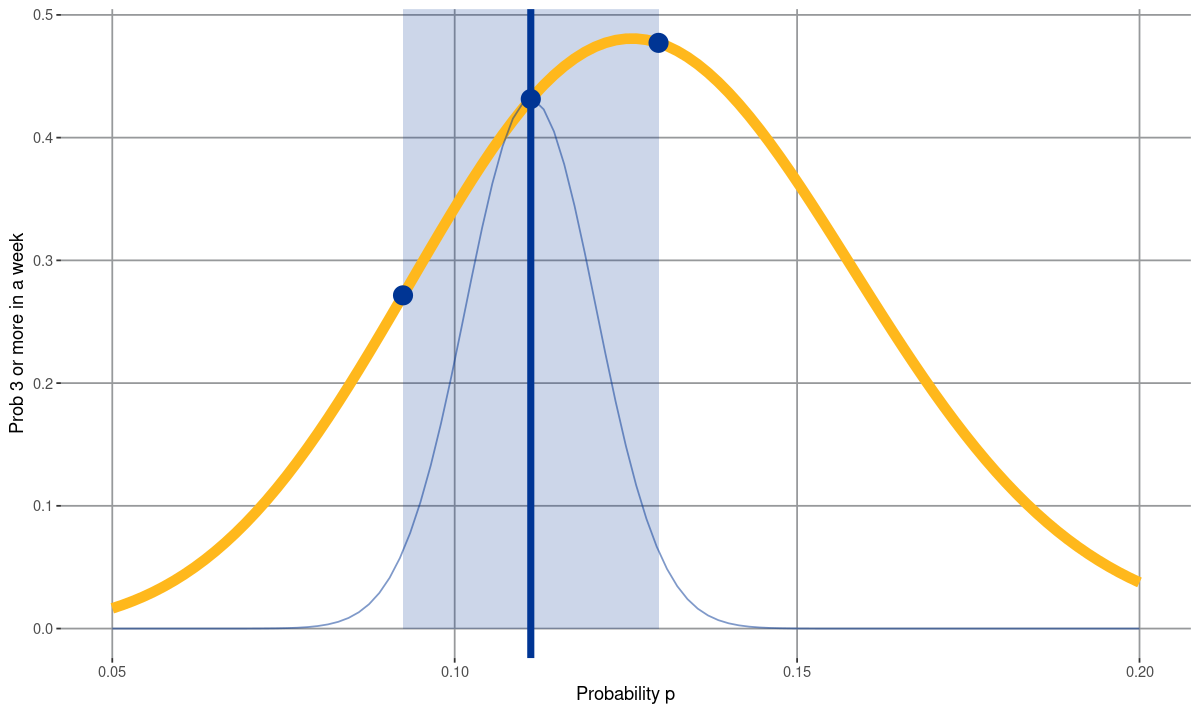

In [20]:
two.or.three <- function(p) dbinom(x=2,size=52, prob=Q(p))+dbinom(x=3,size=52, prob=Q(p))
base + 
geom_rect(aes(xmin=pConfInt["lower.limit"],xmax=pConfInt["upper.limit"],ymin=0,ymax=Inf),alpha=0.2,fill=Pitt.Blue)+ #draw a rectangle for conf-int
geom_function( fun = two.or.three, colour=Pitt.Gold, linewidth=3)+ # draw the NoCall function
geom_vline(xintercept=pHat,color=Pitt.Blue,linewidth=2)+ # draw the vertical line
geom_point(aes(x=pConfInt, y=two.or.three(pConfInt)),color=Pitt.Blue,size=5)+ # Draw the 3 points on the function
# overlay the asymptotic distribution for p scaled to fit
geom_function(fun=function(x) two.or.three(pHat)*dnorm(x,mean=pHat,sd=sigma.p)/dnorm(pHat,mean=pHat,sd=sigma.p), color=Pitt.Blue,alpha=0.5)+  
xlim(0.05, 0.2)+xlab("Probability p")+ylab("Prob 3 or more in a week") 

Here the function is not increasing/decreasing over the parameter $p$ across the interval,  as such the computation of the interval is harder to gauge:

Ideally we would want to identify an interval like this one:

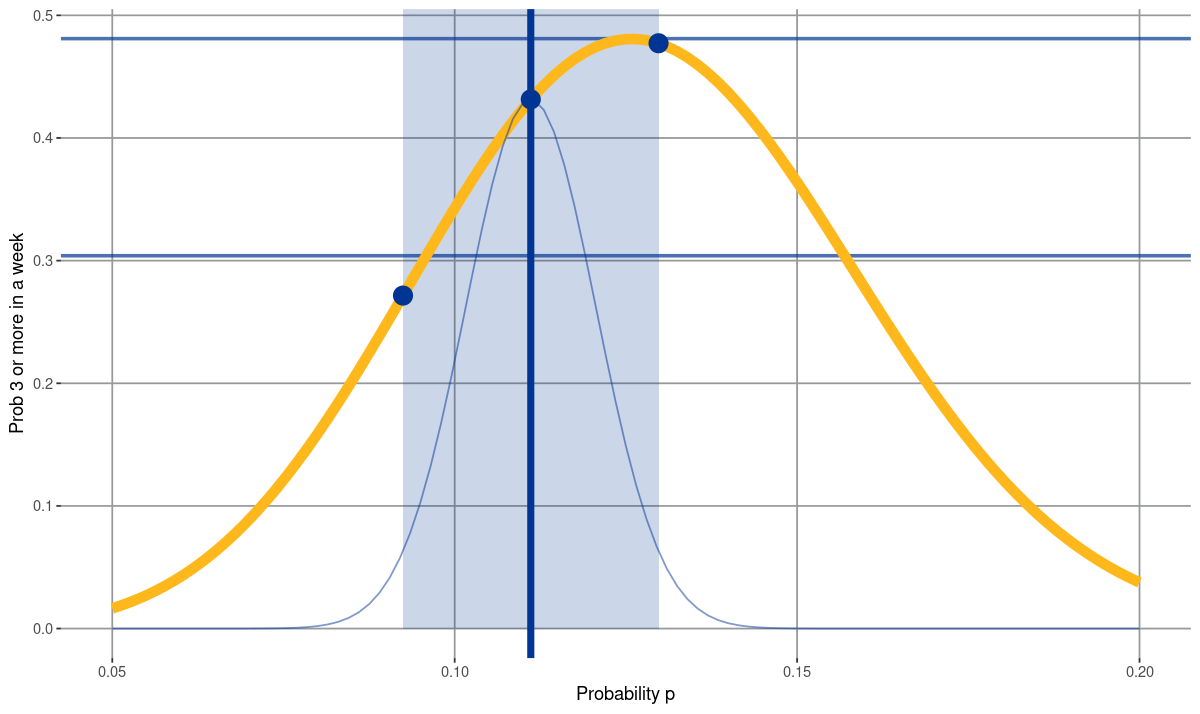

In [21]:
base + 
geom_rect(aes(xmin=pConfInt["lower.limit"],xmax=pConfInt["upper.limit"],ymin=0,ymax=Inf),alpha=0.2,fill=Pitt.Blue)+
geom_hline(yintercept=c(0.304,0.481),color=Pitt.Blue,linewidth=1,alpha=0.7)+
geom_function( fun = two.or.three, colour=Pitt.Gold, linewidth=3)+ # draw the NoCall function
geom_vline(xintercept=pHat,color=Pitt.Blue,linewidth=2)+ # draw the vertical line
geom_point(aes(x=pConfInt, y=two.or.three(pConfInt)),color=Pitt.Blue,size=5)+ # Draw the 3 points on the function
geom_function(fun=function(x) two.or.three(pHat)*dnorm(x,mean=pHat,sd=sigma.p)/dnorm(pHat,mean=pHat,sd=sigma.p), color=Pitt.Blue,alpha=0.5)+  
xlim(0.05, 0.2)+xlab("Probability p")+ylab("Prob 3 or more in a week")

Feasibly, you could calculate the maximal point of this function to figure out the 95% confidence interval... though even this wouldn't necessarily be the exact interval you wanted to calculate

When anything gets even somewhat complicated, I would usually turn to a simulation method to calculate this, as I know:
* the generating distribution for $p$
* and I know the formula for the function

Draw a lot (a whole bunch!) of draws for $p$ from the relevant normal distribution:

In [22]:
pDraws <- rnorm(1e6, mean=pHat,sd=sigma.p)

Apply the function to check whether there's two or three in a year:

In [23]:
out <- sapply(pDraws,two.or.three) 

And look at the quantiles of these 100,000 draws:

In [24]:
head(out) 
quantile(out,c(0.025,0.975))

[1] 0.3232920 0.4806392 0.4788917 0.4671881 0.4148539 0.4290484

2.5%     97.5% 
0.2711916 0.4805322

## The Delta-Method
---
While the above wasn't too hard to calculate more-tailored outcome statistics for, once we move into more multi-dimensional statistics, we need a more-structured method for generating standard errors.

To achieve this, we will again first turn to a large sample approach combined with the Taylor expansion.

That is, suppose we have an estimator $\hat{\theta}$ that is consistent for a parameter $\theta$, and that we know that $\sqrt{n}(\hat{\theta}-\theta)\rightarrow^D \mathcal{N}(0,\Sigma)$. 

However, we want to figure the distribution for a continuous transformation $g(\hat{\theta})$.

Here we make use of the Taylor Expansion again which tells us that  so long as $(\hat{\theta}-\theta)$ is small we can rewrite
$$g(\hat{\theta})=g\left(\theta+(\hat{\theta}-\theta)\right)\simeq g(\theta)+\frac{\partial g(\theta)}{\partial \theta}(\hat{\theta}-\theta)$$

*(Technically the constructions make use of slightly stronger related result called the mean-value theorem...)*

So that means that $$
\sqrt{n}\left(g(\hat{\theta})-g(\theta)\right)
\simeq
\frac{\partial g(\theta)}{\partial \theta}\sqrt{n}\left(\hat{\theta}-\theta\right)
$$

So we conclude that
* if $\sqrt{n}(\hat{\theta}-\theta)\rightarrow^D \mathcal{N}(0,\Sigma)$
* then $\sqrt{n}(g(\hat{\theta})-g(\theta))\rightarrow^D \mathcal{N}(0,\frac{\partial g(\theta)}{\partial \theta^T}\Sigma \frac{\partial g(\theta)}{\partial \theta})$

The above is a lot of math, and may look confusing; however, the fundamental idea is that we can now construct confidence intervals via:
$$g(\hat{\theta})\rightarrow^D \mathcal{N}\Bigl(g(\theta),\frac{1}{N}\frac{\partial g(\theta)}{\partial \theta^T}\Sigma \frac{\partial g(\theta)}{\partial \theta}\Bigr) $$

We just need to plug in estimators for the separate elements:
* an estimator $\hat{\theta}$ for the parameter vector $\theta$
* an estimator $\hat{\Sigma}$ for the variance-covariance matrix $\Sigma$
* an estimator for the derivative vector  for $g(\theta)$ at $\hat{\theta}$

Often the implementation of this will then compute a variance-covariance matrix via:

$$\hat{\Omega}= \frac{1}{N}\frac{\partial g(\hat{\theta})}{\partial \theta^T}\hat{\Sigma} \frac{\partial g(\hat{\theta})}{\partial \theta} $$

This still may seem complicated, but in terms of the coding its relatively easy! We just need:
* A vector called `dG` which as we saw is not hard to numerically compute if we know $g(\cdot)$
* The variance-covariance matrix `Sigma.hat` which we can likely take from most any model in R with the `vcov` command

If you're using a "canned" package, the ensuing code to produce the new variance is then just something as simple as:

For the numerical derivative, we can just use a multivariate analog to our previous finite-difference approximation:

In [25]:
numerical.derivative<- function(fun, x) {
    nn <- length(x) # set nn as the length of input vector x
    dx <- rep(NaN, nn) # initialize the derivative vector
    for (i in 1:nn) {
        eps <- rep(0,nn) # set epsilon as a zero vector (0,0,..,0)
        eps[i] <- 1e-6 # put a small shift on coordinate i
        # now calculate the derivative using centered difference method
        dx[i] <- (fun(x+eps)-fun(x-eps))/(2e-6) 
        }
    return(dx) # return the numerical derivative vector
}

## Quick Example
---
Let's generate a Poisson model where each row's means is given by 
$$\lambda_i=\exp\left\{\beta_1+\beta_2 x_{1i}+\beta_3 x_{2i}\right\}$$
for observables $x_1$ and $x_2$, where we'll force $\beta_1=2$, $\beta_2=-1$and  $\beta_3=1$


In [26]:
# Draw x1 and x2 observables from normal, rounded to 2 decimals
x1 <- round( rnorm(1000,mean=0,sd=0.5), 2)
x2 <- round( rnorm(1000,mean=-1,sd=0.8) , 2)
beta <- c(2,-1, 1) # set the true beta vector
# Set the mean for each of the 1000 observations
lambda <- exp(beta[1]+beta[2]*x1 +beta[3]*x2)
# Draw a Poisson from the relevant distribution
generateY <- function(lambda.i) rpois(1,lambda=lambda.i)
# so here we draw y_i from a posisson with mean of
#           lambda_i=exp(2 -x1_i + x2_i )
y <- sapply(lambda,generateY)

In [27]:
# Put it into a dataframe
data.Pois <- data.frame(cbind(y=y,x1=x1,x2=x2))
head(data.Pois,4 ) 

,y,x1,x2
,<dbl>,<dbl>,<dbl>
1,3,-0.38,-0.50
2,0,0.49,-2.03
3,9,-0.24,-0.05
4,4,0.26,-0.86


Let's estimate the model with the built in `glm()` estimation model as this fits into the generalized linear model framework (more on this later):

In [28]:
pois.model <- glm( y ~ x1+x2, data=data.Pois, family="poisson")
summary(pois.model)
beta.hat <- coef(pois.model)
beta.hat


Call:
glm(formula = y ~ x1 + x2, family = "poisson", data = data.Pois)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.98426    0.01945  102.03   <2e-16 ***
x1          -0.97429    0.03299  -29.53   <2e-16 ***
x2           0.98842    0.02129   46.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 4113.2  on 999  degrees of freedom
Residual deviance: 1066.3  on 997  degrees of freedom
AIC: 3679.6

Number of Fisher Scoring iterations: 5


(Intercept)          x1          x2 
  1.9842550  -0.9742872   0.9884151

In [30]:
confint(pois.model)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),1.9458690,2.0221026
x1,-1.0389905,-0.9096593
x2,0.9467403,1.0301798


The model automatically calculates the variance-covariance matrix for the parameter vector where we are using this as:
$$\hat{\beta}\sim \mathcal{N}(\beta,\tfrac{1}{n}\hat{\Sigma}) $$

In [31]:
Sigma.hat.divN <- vcov(pois.model)
Sigma.hat.divN

,(Intercept),x1,x2
(Intercept),0.0003781815,2.069817e-04,1.878070e-04
x1,0.0002069817,1.088537e-03,-4.115415e-05
x2,0.0001878070,-4.115415e-05,4.530919e-04


Suppose that we want to calculate the probability that the count variable is 0 when $x_1=1$ and $x_2=-2$?

So we want the probability that the value is 0 which is given by
$$ \Pr\left\{X=0\right\}=e^{-\lambda}$$
where $\lambda=\exp\left\{\beta_1 +\beta_2-2\beta_2 \right\}$.


In [32]:
prob.pois.0 <-  function( beta ) dpois(0,lambda=exp(beta[1]+beta[2]-2*beta[3]) ) # define the function
dG <- numerical.derivative(prob.pois.0,beta.hat) # use our vector numerical diff function on it
dG

[1] -0.2599836 -0.2599836  0.5199672

The previous estimation gave us the variance-covariance matrix, the $\tfrac{1}{n}\hat{\Sigma}$ term. From the Taylor expansion we know that:
$$g(\hat{\theta})\rightarrow^D \mathcal{N}\Bigl(g(\theta),\Omega\Bigr) $$
with the variance:
$$\hat{\Omega}= \frac{\partial g(\hat{\theta})}{\partial \theta^T}\left(\frac{1}{n}\hat{\Sigma}\right) \frac{\partial g(\hat{\theta})}{\partial \theta} $$

In [33]:
Omega.hat <- t(dG)%*% Sigma.hat.divN %*% dG 
Omega.hat
prob.pois.0(beta.hat)
sqrt(Omega.hat)

0.0002099687


[1] 0.6836738

0.0144903


So we not have an estimate and a standard-error/CI for the probability of a zero:

In [34]:
delta.method.out <- c("estimate of zero"=prob.pois.0(beta.hat), 
                      "std.err"= sqrt(Omega.hat), 
                      "lower.conf"= prob.pois.0(beta.hat)-1.96*sqrt(Omega.hat),
                      "upper.conf"= prob.pois.0(beta.hat)+1.96*sqrt(Omega.hat) )
delta.method.out

estimate of zero          std.err       lower.conf       upper.conf 
       0.6836738        0.0144903        0.6552729        0.7120748

### Check our answer against Simulation
---
There are packages that will automate these numerical derivatives in a slightly better way... however, to see how this stacks up we will compare it to a simulation option:
* Draw values of $\beta$ from the relevant multivariate normal, and simulate the calculation 

In [35]:
#install.packages('MASS')
library(MASS) # we need this to get the multivariate random normal distribution
beta.draws <- replicate(5e5, # replicate things 50000 times
                        prob.pois.0( #Figure out the Prob under a Poisson of a zero outcome
                            mvrnorm(1,mu=beta.hat,Sigma=Sigma.hat.divN) # Draw a value of beta hat from the asymptotic distribution
                        ) 
                       )

In [36]:
simulation.out <-c("estimate of zero"=mean(beta.draws),
                   "std.err"= sd(beta.draws),
                   "lower.conf"=quantile(beta.draws,0.025,names=FALSE), # I set names FALSE here to stop quantile names being appended
                   "upper.conf"=quantile(beta.draws,0.975,names=FALSE))
simulation.out

estimate of zero          std.err       lower.conf       upper.conf 
      0.68343578       0.01449318       0.65436480       0.71108459

Comparing the two methods (here I bind them together as columns using `cbind()` for easier comparisons):

In [37]:
round(# Rounding to 4 dp for clarity
cbind(simulation=simulation.out,delta.method=delta.method.out,difference=simulation.out-delta.method.out),4)

,simulation,delta.method,difference
estimate of zero,0.6834,0.6837,-2e-04
std.err,0.0145,0.0145,0e+00
lower.conf,0.6544,0.6553,-9e-04
upper.conf,0.7111,0.7121,-1e-03


# Resampling methods
---
Another popular method for generating the standard-errors moves away from using the asymptotic distribution. Instead, it uses the data itself to approximate the sampling distribution for the estimators 

## Resampling Flavors
This technique comes in a number of flavors, where I'll just let you know the names and then will focus on outlining just one of these:
* **Bootstrapping** : This is where we randomly resample $n$ observations from the original $n$ with replacement, and repeat this many times
* **Jackknifing**: This is where we remove a data point $i$ and use the remaining $n-1$ observations, repeat this for each possible row to remove
* **Sub-sampling**: Here we take a sub-sample (without replacement) of size $m$ from the original data, and repeat this many times (this method is a bit more complex, but can be consistent under weaker assumptions)

## Bootstrapping
Here we'll focus on bootstrapping techniques, as they're the most common:

* The basic idea here is that we have a data set $\mathbf{Z}= \left[\mathbf{y} , \mathbf{X}\right]$ with generic elements in row $i$ given by $(y_i , \mathbf{x}_i)$.
* We will use the idea that we can use the empirical distribution of the data $\mathbf{Z}$ as a stand-in for the actual distribution of $z_i$.
* As such, we can assemble the sampling distribution for the estimator by drawing a new sample of size $n$ and calculating our estimator!


We'll use the `boot` package to make our lives much easier here:

In [38]:
#install.packages('boot')
library(boot)

In [39]:
head(data.Pois,2)

,y,x1,x2
,<dbl>,<dbl>,<dbl>
1,3,-0.38,-0.50
2,0,0.49,-2.03


In [40]:
pois.bs <- function(formula, data, indices) {
  d <- data[indices,]
  pois.fit <- glm(formula, data=d,family="poisson")
  # Return the probability of a 0 when x1=1, and  x2=-2
  return( prob.pois.0(coef(pois.fit)) )  
}
bs.results.prob.0 <- boot(data=data.Pois, statistic=pois.bs,
   R=10000, formula=y~x1+x2)

Get the bootstrapped statistics

In [41]:
bs.distribution <- bs.results.prob.0$t 

We can illustrate the boostrapped distribution with a histogram:

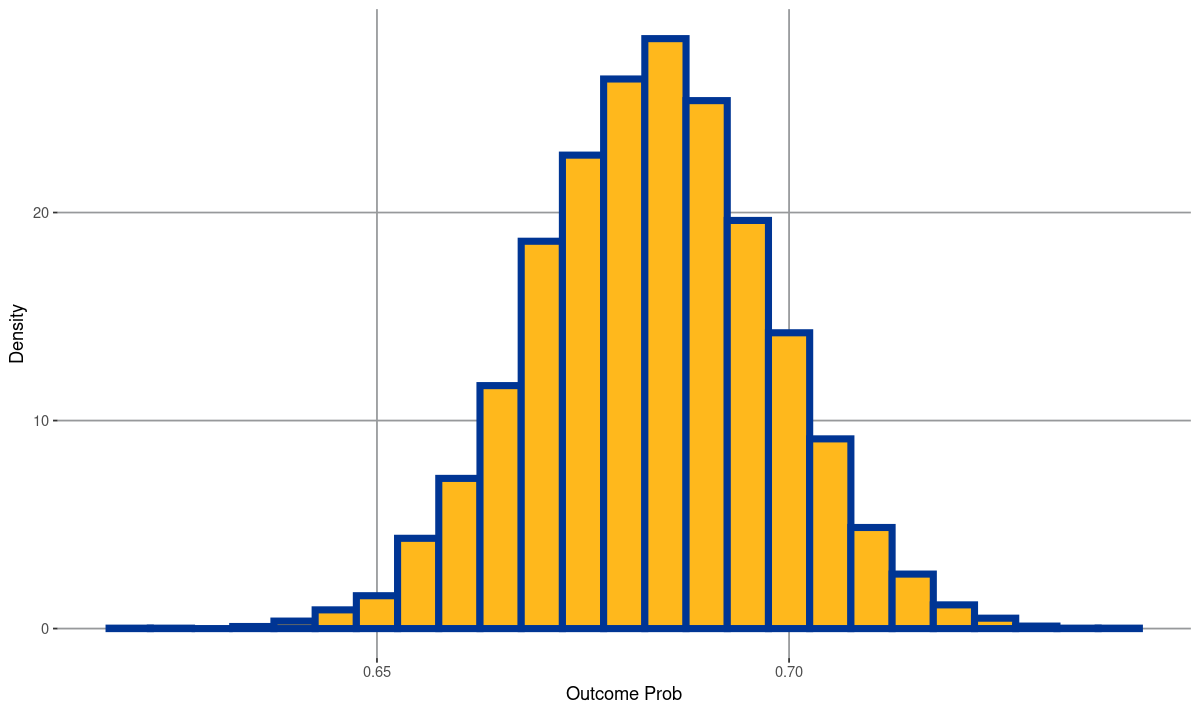

In [42]:
base + geom_histogram(aes(x=bs.distribution,y =after_stat(density)),binwidth=0.005,color=Pitt.Blue,fill=Pitt.Gold,linewidth=2)+xlab("Outcome Prob")+ylab("Density")

Assembling the results:

In [43]:
bootstrap.out <-c("estimate"=mean(bs.distribution),
                   "std.err"= sd(bs.distribution),
                   "lower.conf"=quantile(bs.distribution,0.025,names=FALSE), # I set names FALSE here to stop quantile names being appended
                   "upper.conf"=quantile(bs.distribution,0.975,names=FALSE))
bootstrap.out

estimate    std.err lower.conf upper.conf 
0.68343015 0.01435663 0.65503170 0.71145767

And we can compare it to what we got from the Asymptotic Normal approach above (with $\Delta$-method and Simulation)

In [44]:
round(
    cbind(simulation=simulation.out,delta.method=delta.method.out,bootstrap=bootstrap.out),4)

,simulation,delta.method,bootstrap
estimate of zero,0.6834,0.6837,0.6834
std.err,0.0145,0.0145,0.0144
lower.conf,0.6544,0.6553,0.6550
upper.conf,0.7111,0.7121,0.7115


The bootstrap approach can also be used to figure out the standard errors more generally:

In [45]:
pois.bs <- function(formula, data, indices) {
  d <- data[indices,]
  pois.fit <- glm(formula, data=d,family="poisson")
  # Return the coefficients of the glm model
  return( coef(pois.fit) ) 
}
bs.results <- boot(data=data.Pois, statistic=pois.bs,R=1000, formula=y~x1+x2)

We can also use the built-in `boot.ci( )` function to get slightly cleverer confidence intervals for each of the estimated elements:

In [46]:
boot.ci(bs.results,type="bca",index=2) #  x1

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bs.results, type = "bca", index = 2)

Intervals : 
Level       BCa          
95%   (-1.0403, -0.9133 )  
Calculations and Intervals on Original Scale

In [47]:
boot.ci(bs.results,type="bca",index=3) #  x2

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bs.results, type = "bca", index = 3)

Intervals : 
Level       BCa          
95%   ( 0.9459,  1.0308 )  
Calculations and Intervals on Original Scale

The `bca` here stands for *adjusted bootstrap percentile* method, where it's just being slightly more sophisticated about how it pick the limits here in the tails of the 1000 draws we made.

While we can be more sophisticated about it, we can also figure out things like the variance covariance matrix simply by looking at how the resampled estimates are empirically related

In [48]:
bs.Sigma <- cov( bs.results$t) # get the covariance matrix
rownames(bs.Sigma) <- c("(Intercept)","x1","x2")
colnames(bs.Sigma) <- c("(Intercept)","x1","x2")
bs.Sigma # Matrix

,(Intercept),x1,x2
(Intercept),0.0003400573,1.746475e-04,1.712421e-04
x1,0.0001746475,1.094673e-03,-8.496057e-05
x2,0.0001712421,-8.496057e-05,4.588598e-04


Which we can compare to our estimates from the asymptotic Normal approach from before:

Sigma.hat.divN # Matrix

So the standard errors under these really quite distinct methods are fairly close here.

In [49]:
sqrt(diag(bs.Sigma)) # Std. Errors for each parameter in isolation bootstrap
sqrt(diag(Sigma.hat.divN)) # Std. Errors for each parameter in isolation delta method

(Intercept)          x1          x2 
 0.01844064  0.03308584  0.02142101

(Intercept)          x1          x2 
 0.01944689  0.03299298  0.02128596

## Bootstrap Usage
---
Bootstraps are very useful ways of assessing standard errors, and are almost more intuitive than the asymptotic Central Limit results. There are however some pros and cons: 

### Pros
* We're assuming very little about the error structure here, and certainly we're not putting a parametric distribution on it
    * In many cases bootstrapped confidence intervals can be more accurate than the asymptotic normals 
* By drawing random samples we're examining how over or under weighing extreme observations could affect the estimates
    * If you want you can therefore just view this as a test of the "stability" of the results
* It's constructed directly over the estimation procedure we're using, and so is more holistic
* Once we have the sampling distribution for out estimated parameters, we can use it to ask whatever question we want

### Cons
* We do need a *moderate* sample for the empirical distribution to be a good estimator for the true data generating process
* It can be slow if the estimation routine that we're bootstrapping also takes a long time
* If there is a dependence structure to the data, this needs to be included into the bootstrap
    * For example, in time series, the bootstrap sampling scheme has to be adjusted as rows are not independent
    * Similarly, if there are strata to the data (control/treatment, matching groups, etc) the bootstrap should be adjusted 
* There are a few situations where you shouldn't use bootstraps:
    * Extreme values
    * Distributions with *fat* tails (infinite moments)
    


# Likelihood Ratio Tests
---
Another feature of tests within maximum likelihood estimation that does get used a fair amount is what's called a likelihood ratio test. To do this we:
* Enforce a constraint on the Likelihood maximization process, where this constraint mirrors our null hypothesis $H_0$.
    * Estimate the parameters under the constraint $\tilde{\theta}_{H_0}$ and obtain a log-likelihood $l(\tilde{\theta}_{H_0})$ under the constraints
* We also run the unconstrained version, where the data picks the values for all of the parameters $\hat{\theta}$
    * This has log likelihood given by $l(\hat{\theta})$ 

The likelihood ratio test statistic is then given by:
$$\lambda_{H_0}=2 \left(l(\hat{\theta})-l(\tilde{\theta}_{H_0})\right)$$
where this quantity is always positive (the unrestricted maximizer has to be weakly larger!)

If the null hypothesis is true, then the likelihood ratio test statistic will converge to a $\chi^2_k$ distribution ($k$ standard normals all-squared and summer)
* We can then use knowledge of the $\chi^2_k$ distribution to test our Null hypothesis
* $k$ is the difference in dimension enforced by the constraints

As an example, let's go back to our Poisson data and estimate a constraint that $H_0:\beta_2=1$

In [63]:
pois.unc <- glm( y~ x1+x2, data=data.Pois, family="poisson") # unconstrained
pois.con<- glm(  y~ x1+offset(1*x2), data=data.Pois, family="poisson") #constrained
beta.unc <- coef(pois.unc) 
beta.con <- coef(pois.con)
beta.unc 
beta.con

(Intercept)          x1          x2 
  1.9842550  -0.9742872   0.9884151

(Intercept)          x1 
  1.9890182  -0.9753452

We could write a formula to calculate the log likelihood here:

In [64]:
poisson.lik<-function(y,mu){   
n <-nrow(y)
logl <- sum( y * log(mu) - mu -log(factorial(y))) # in any difference the log(k!) will be differenced out, but include anyway
return(logl)
}


and then run it on the estimated parameters:

In [65]:
log.lik.unc <- poisson.lik(data.Pois["y"], 
      exp( beta.unc["(Intercept)"]+beta.unc["x1"]*data.Pois["x1"]+ beta.unc["x2"]*data.Pois["x2"] ) )
log.lik.con <- poisson.lik(data.Pois["y"], 
       exp( beta.con["(Intercept)"]+beta.con["x1"]*data.Pois["x1"]+ 1.5*data.Pois["x2"] ) )

And calculate the likelihood ratio test statistic:

In [66]:
LR.test.stat <- 2*( log.lik.unc-log.lik.con )
c("test.stat"=LR.test.stat, "p.value"=1-pchisq(LR.test.stat,df=1)) 

test.stat   p.value 
 644.4288    0.0000

If we're using GLM methods though we can use prepackaged versions for this using:

In [67]:
#install.packages('lmtest')
library(lmtest)
pois.unc <- glm(y~ x1+x2, data=data.Pois, family="poisson") # unconstrained
pois.con<- glm(y~ x1+offset(1.5*x2), data=data.Pois, family="poisson") #constrained
lrtest(pois.unc,pois.con) 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,-1836.797,NA,NA,NA
2,2,-2118.048,-1,562.502,2.40078e-124


Similarly, we could have extracted the log-likelihoods directly via from our estimated GLM models:

In [68]:
logLik(pois.unc)
logLik(pois.con)

'log Lik.' -1836.797 (df=3)

'log Lik.' -2118.048 (df=2)

So given this quicker method, let's consider a joint test for whether: 
* the `x1` effect is -1 
* and the `x2` effect is 1

In [69]:
pois.con.2<- glm(y~ offset(-1*x1) +offset(1*x2), data=data.Pois, family="poisson")
lrtest(pois.unc,pois.con.2)
# p value here from 1-pchisq(Test.Stat, df=2)  because we drop 2 degrees of freedom

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,-1836.797,NA,NA,NA
2,1,-1837.225,-2,0.8560105,0.651808


## How to choose between models?
---
One last note, as we move into more practical Max-Likelihood applications, is how to assess different models.

We would like something like the adjusted $R^2$ measure from linear regression, where we can compare two different models and examine the tradeoffs over:
* The simplicity of the model and number of parameters
* How well the model fits the data

I'll just briefly outline two often used criteria for this comparison, where the two key parameters will be:
* Simplicity: number of different parameters $k$ that we estimate in $\boldsymbol{\theta}$
* Goodness of Fit : the log likelihood $\log \left(L(\boldsymbol{\theta})\right)$

**What directions to we want for $k$ and $L$ ??**

### Akaike Information Criterion (AIC)
The AIC for a model is derived from theory for the possible information contained in a model and is given by:
$$ \text{AIC}= 2 k -2 \log L $$

### Bayesian Information Criterion (BIC)
The BIC for a model is similar, though the derivation based on slightly different theory:
$$ \text{BIC}= k \log(n) -2 \log( L) $$

Both of these criteria can be used to choose between two models, where the **lower** is the number the better! For example, the *AIC* is generically reported in the output to GLM model:

In [70]:
data.Pois["eps"] <- rnorm(1000) 

In [71]:
model1 <-  glm(y~ x1+x2, data=data.Pois, family="poisson")

# Adding random noise as a regressor!
model2 <-  glm(y~ x1+x2+eps, data=data.Pois, family="poisson")

In [73]:
#summary(model1)
summary(model2)


Call:
glm(formula = y ~ x1 + x2 + eps, family = "poisson", data = data.Pois)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.98394    0.01945 101.981   <2e-16 ***
x1          -0.97359    0.03299 -29.510   <2e-16 ***
x2           0.98801    0.02129  46.398   <2e-16 ***
eps          0.01353    0.01626   0.832    0.405    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 4113.2  on 999  degrees of freedom
Residual deviance: 1065.6  on 996  degrees of freedom
AIC: 3680.9

Number of Fisher Scoring iterations: 5


### Built in commands
AIC:

In [74]:
AIC(model1)
AIC(model2)

[1] 3679.595

[1] 3680.903

BIC:

In [75]:
BIC(model1)
BIC(model2)

[1] 3694.318

[1] 3700.534